In [1]:
from __future__ import division, print_function

from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
import warnings

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import scipy.stats as scs
from scipy.optimize import minimize

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')

## 1. Скачать датасет Х.

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('input/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## 2. Используя модель ARIMA из лекции, перебором подобрать наилучший набор параметров.

In [3]:
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

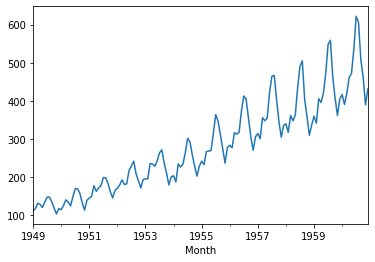

In [4]:
ts.plot()

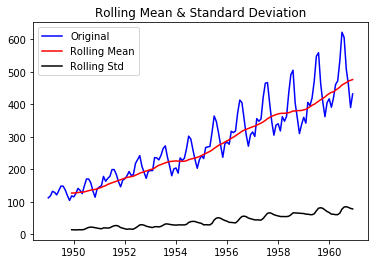

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Задаем скользящие
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Отрисовываем
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Выполняем тест Дики-Фуллера
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    
test_stationarity(ts)

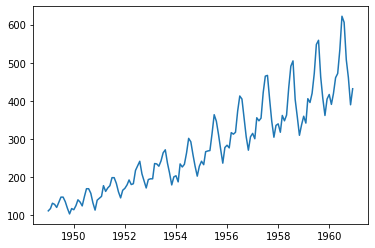

In [6]:
plt.plot(ts)

In [7]:
ts_log = np.log(ts)

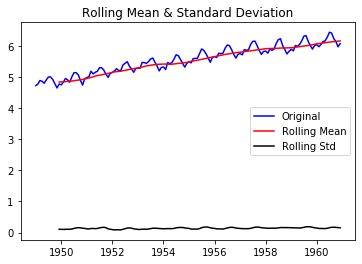

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [8]:
test_stationarity(ts_log)

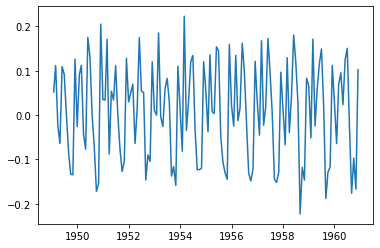

In [9]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

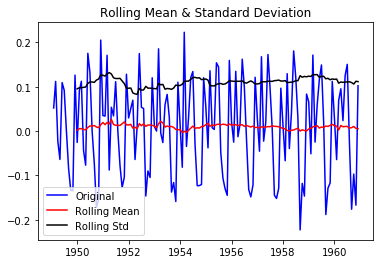

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [10]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

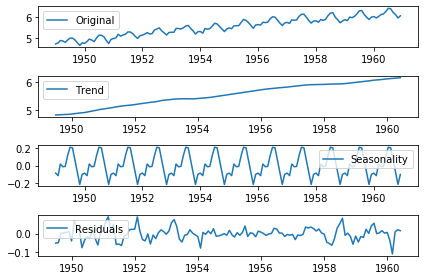

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

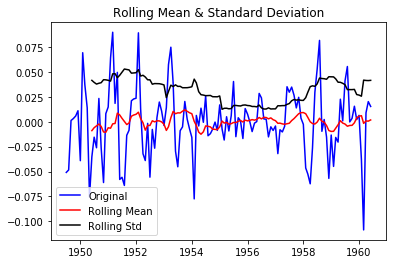

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [12]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [13]:
from statsmodels.tsa.stattools import acf, pacf

In [14]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

In [15]:
q = 2
p = 2

In [16]:
from statsmodels.tsa.arima_model import ARIMA  # (p,d,q)

Text(0.5, 1.0, 'RSS: 1.0292')

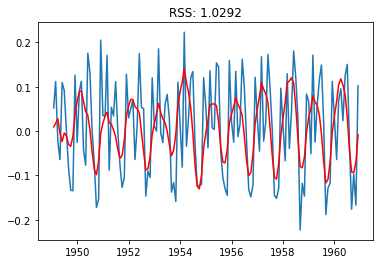

In [17]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RMSE: 90.1046')

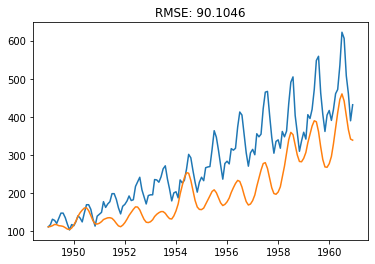

In [18]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [19]:
p = range(0, 3)
d = (1,)
q = range(0, 2)

from itertools import product

parameters = product(p, d, q)
parameters_list = list(parameters)
len(parameters_list)

6

In [20]:
for p, d, q in parameters_list:
    model = ARIMA(ts_log, order=(p, d, q))  
    results_ARIMA = model.fit(disp=-1)  
    rss = sum((results_ARIMA.fittedvalues - ts_log_diff)**2)
    print('for p={}, d={}, q={} RSS is {}'.format(p, d, q, rss))



for p=0, d=1, q=0 RSS is 1.6122981858491325
for p=0, d=1, q=1 RSS is 1.5245381576171468
for p=1, d=1, q=0 RSS is 1.5476170226794264
for p=1, d=1, q=1 RSS is 1.4597312936065656
for p=2, d=1, q=0 RSS is 1.5023033684407843
for p=2, d=1, q=1 RSS is 1.1753125219005036


Text(0.5, 1.0, 'RSS: 0.9832')

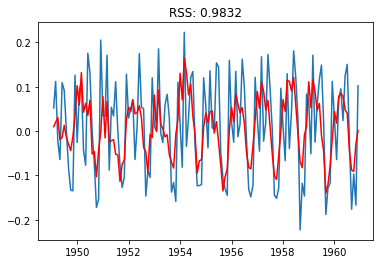

In [21]:
model = ARIMA(ts_log, order=(3, 1, 3))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RMSE: 81.6668')

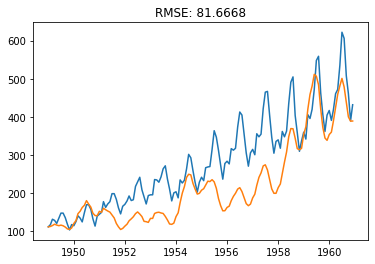

In [22]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV



from sklearn.base import BaseEstimator
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

def revert(results_ARIMA):
    predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
    predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
    predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
    predictions_ARIMA = np.exp(predictions_ARIMA_log)
#     plt.plot(ts)
#     plt.plot(predictions_ARIMA)
#     plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
    return predictions_ARIMA

class ArimaEstimator(BaseEstimator):  
    def __init__(self, p, d, q, **kwargs):
        self.p = p
        self.d = d
        self.q = q
    
    def fit(self, X, y=None):
        self._orig_arima = ARIMA(X, order=(self.p, self.d, self.q))
        self._results_arima = self._orig_arima.fit(disp=-1)  
#         self.rss = sum((results_ARIMA.fittedvalues - ts_log_diff)**2)
        
# # #         self.get_model_instance().fit(X, y)
# # #         return self
# # #         self.model_instance = models[self.name]
# #         self.model_instance.fit(X, y)

        return self

    def predict(self, X, y=None):
#         print('PREDICT', X.shape, X)
#         print('REVERT', revert(self._results_arima))
        return revert(self._results_arima)
#         return revert(self._results_arima)
        
# # #         return self.get_model_instance().predict(X)
# # #         self.model_instance = models[self.name]
# #         return list(map(int, self.model_instance.predict(X)))
#         return self.rss

    
    def score(self, X, y=None):
#         print('SCORE', X.shape, y.shape)
#         print('PREDICTED', self.predict(X))
#         error = mean_squared_error(self.predict(X), 1), y)
#         n = self.predict(X).shape[0]
        n = y.shape[0]
#         print('N', n)
        error = mean_squared_error(np.array(X)[:n].reshape((n, 1)), y)
        score = 1 / (1 + error)
#         print('.', end='')
        return score



pipeline = Pipeline(steps = [
# #     ('feature_selector', FunctionTransformer(feature_selector, validate=False)),

# #     ('imputer', SimpleImputer(strategy='most_frequent')),
# #     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
# #     ('scaler', StandardScaler()),      
    
    
# #     ('model', Router('log_reg', estimator=None, x_pred=x_test, y_true=y_true))
        ('model', ArimaEstimator(p=1, d=1, q=1))
])

print('L', list(range(1, 3)))

grid = {
    'model__p': range(2, 4),
    'model__d': range(1, 3),
    'model__q': range(2, 4),
}



# def estimator(model):
#     print(model)
# #         x = preparation.fit_transform(x_test)
#     model.fit(_x_train, _y_train)
# #         print(model.predict(x).shape, y_true.shape)
#     return accuracy_score(y_pred=list(map(int, model.predict(_x_test))), y_true=_y_true)


search_cv = GridSearchCV(pipeline, grid, cv=3, iid=True)
# print('SHAPE', np.array(ts_log).shape)
# print(np.array(ts_log).reshape((1, np.array(ts_log).shape[0])))
# print('2')
# search_cv.fit(np.array(ts_log).reshape((np.array(ts_log).shape[0], 1)), np.array(ts_log))
search_cv.fit(ts_log, ts_log)



search_cv.best_estimator_

# model = ArimaEstimator(p=3, d=1, q=3)
# model.fit(ts_log)

# plt.plot(ts)
# plt.plot(model.predict([]))

# model.score(X=model.predict([]), y=ts)